In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from feature_engine.imputation import RandomSampleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((425, 23), (183, 23))

In [4]:
imputer  = RandomSampleImputer(random_state=42)
imputer.fit(X_train)

RandomSampleImputer(random_state=42)

In [5]:
X_train_t = imputer.transform(X_train)
X_test_t = imputer.transform(X_test)

dataframes = [
    X_train_t, X_test_t, 
]

for df in dataframes:
    if df.isna().any().all() == False:
        print("No missing values in any dataframe")
        break
    else:
        print("Still missing values")

No missing values in any dataframe


### Stratified Cross-Validation


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score, make_scorer
import numpy as np

def run_random_forest(classifier_name, imp_method, X_train, y_train):

        # Initialize the Random Forest with class weight balancing
        rf = RandomForestClassifier(n_estimators=100,
                                    max_depth=5,
                                    random_state=42,
                                    class_weight="balanced",
        )
        
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        metrics = {"accuracy": make_scorer(accuracy_score),
                   "balanced_accuracy": make_scorer(balanced_accuracy_score),  
                   "precision": make_scorer(precision_score, average="weighted"), 
                   "recall": make_scorer(recall_score, average="weighted"), 
                   "f1_weighted": make_scorer(f1_score, average="weighted"),
                   "roc_auc_ovr_weighted": make_scorer(roc_auc_score, 
                                                       average="weighted", 
                                                       multi_class="ovr", 
                                                       response_method="predict_proba",),
        }
        
        cross_val_results = cross_validate(rf,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring=metrics,
                                           return_train_score=True,
        )
                
        metric_names = list(metrics.keys())
        mean_train = [round(np.mean(cross_val_results[f"train_{metric}"]), 3) for metric in metric_names]
        std_train = [round(np.std(cross_val_results[f"train_{metric}"]), 3) for metric in metric_names]
        mean_test = [round(np.mean(cross_val_results[f"test_{metric}"]), 3) for metric in metric_names]
        std_test = [round(np.std(cross_val_results[f"test_{metric}"]), 3) for metric in metric_names]
        time = round(np.mean(cross_val_results[f"fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Classifier": classifier_name,
                "Imputation": imp_method,
                "Fit Time": time,
                "Metric": metric_names,
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = rf.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [7]:
trained_model, model_metrics = run_random_forest("Random Forest", "Random Sample", X_train_t, y_train)

In [8]:
model_metrics
validation_df_report = model_metrics.set_index(["Classifier", "Imputation", "Fit Time", "Metric"])
validation_df_report

Mean Train  \
Classifier    Imputation    Fit Time Metric                             
Random Forest Random Sample 0.334    accuracy                   0.892   
                                     balanced_accuracy          0.900   
                                     precision                  0.897   
                                     recall                     0.892   
                                     f1_weighted                0.889   
                                     roc_auc_ovr_weighted       0.982   

                                                           Std Train  \
Classifier    Imputation    Fit Time Metric                            
Random Forest Random Sample 0.334    accuracy                  0.013   
                                     balanced_accuracy         0.012   
                                     precision                 0.012   
                                     recall                    0.013   
                                     f1_weighted               0.014   
                                     roc_auc_ovr_weighted      0.002   

                                                           Mean Test  Std Test  
Classifier    Imputation    Fit Time Metric                                     
Random Forest Random Sample 0.334    accuracy                  0.616     0.066  
                                     balanced_accuracy         0.547     0.074  
                                     precision                 0.607     0.061  
                                     recall                    0.616     0.066  
                                     f1_weighted               0.599     0.065  
                                     roc_auc_ovr_weighted      0.823     0.041

C:\Users\steve\AppData\Local\Temp\ipykernel_18804\775175312.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc="lower right")


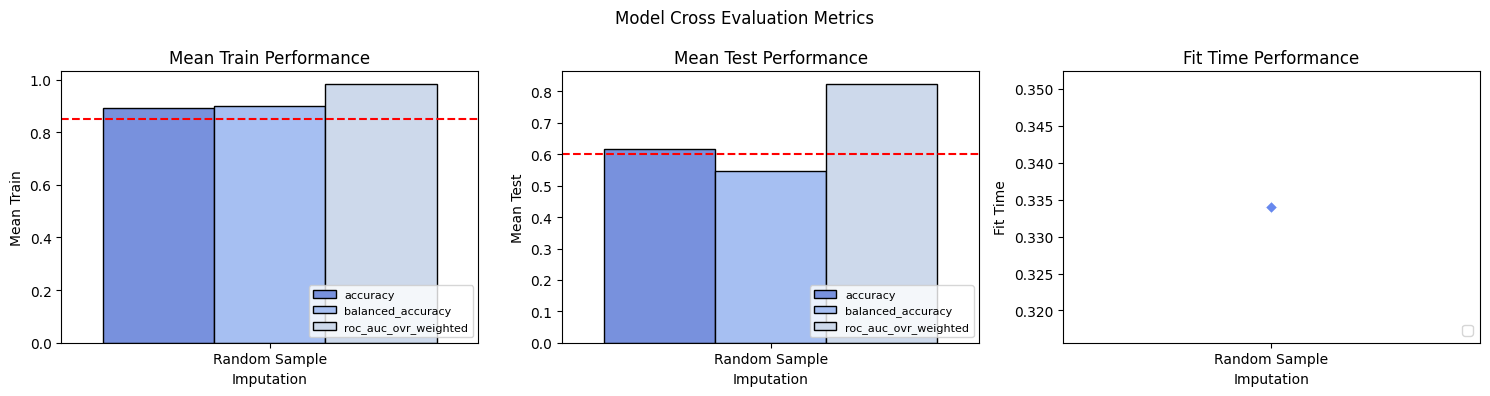

In [9]:
# Filter the metrics you want to plot (Fit Time, Accuracy, Balanced Accuracy, ROC AUC)
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'roc_auc_ovr_weighted']
filtered_df_validation = model_metrics[model_metrics['Metric'].isin(metrics_to_plot)]
filtered_df_validation

sns.set_palette("coolwarm")
fig, axs = plt.subplots(1,3, figsize = (15, 4))

plt.suptitle("Model Cross Evaluation Metrics")
sns.barplot(data=filtered_df_validation, x='Imputation', y='Mean Train', hue='Metric', edgecolor='black', ax = axs[0])
axs[0].legend(loc="lower right",  fontsize=8)
axs[0].axhline(y=0.85, color='red', linestyle='--', linewidth=1.5) 
axs[0].set_title("Mean Train Performance")

sns.barplot(data=filtered_df_validation, x='Imputation', y='Mean Test', hue='Metric', edgecolor='black', ax = axs[1])
axs[1].legend(loc="lower right",  fontsize=8)
axs[1].axhline(y=0.60, color="red", linestyle="--", linewidth=1.5)
axs[1].set_title("Mean Test Performance")

sns.lineplot(data=filtered_df_validation, x='Imputation', y=filtered_df_validation['Fit Time'], marker="D", ax = axs[2])
axs[2].legend(loc="lower right")
axs[2].set_title("Fit Time Performance")

plt.tight_layout()

### Evaluate

In [10]:
import time

def eval_random_forest(classifier_name, imp_method, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Classifier": classifier_name,
                "Imputation": imp_method,
                "Classification Time": round(elapsed_time, 3),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [11]:
pred = eval_random_forest("Random Forest", "Random Sampling", trained_model, X_train_t, X_test_t, y_train, y_test)
prediction_df_report = pred.set_index(["Classifier", "Imputation", "Classification Time", "Metric"])
prediction_df_report

Train data  \
Classifier    Imputation      Classification Time Metric                             
Random Forest Random Sampling 0.129               accuracy                   0.889   
                                                  balanced_accuracy          0.900   
                                                  precision                  0.893   
                                                  recall                     0.889   
                                                  f1_weighted                0.887   
                                                  roc_auc_ovr_weighted       0.977   

                                                                        Test data  
Classifier    Imputation      Classification Time Metric                           
Random Forest Random Sampling 0.129               accuracy                  0.508  
                                                  balanced_accuracy         0.510  
                                                  precision                 0.494  
                                                  recall                    0.508  
                                                  f1_weighted               0.490  
                                                  roc_auc_ovr_weighted      0.811

C:\Users\steve\AppData\Local\Temp\ipykernel_18804\1530920089.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc="lower right")


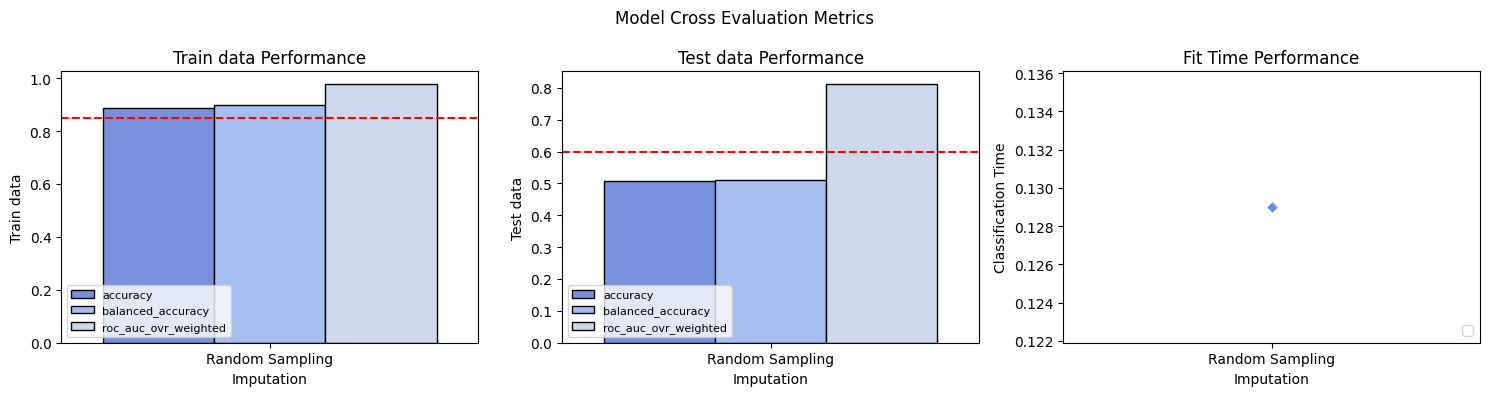

In [12]:
# Filter the metrics you want to plot (Fit Time, Accuracy, Balanced Accuracy, ROC AUC)
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'roc_auc_ovr_weighted']
filtered_df_evaluation = pred[pred['Metric'].isin(metrics_to_plot)]
filtered_df_evaluation

sns.set_palette("coolwarm")
fig, axs = plt.subplots(1,3, figsize = (15, 4))

plt.suptitle("Model Cross Evaluation Metrics")
sns.barplot(data=filtered_df_evaluation, x='Imputation', y='Train data', hue='Metric', edgecolor='black', ax = axs[0])
axs[0].legend(loc="lower left",  fontsize=8)
axs[0].axhline(y=0.85, color='red', linestyle='--', linewidth=1.5) 
axs[0].set_title("Train data Performance")

sns.barplot(data=filtered_df_evaluation, x='Imputation', y='Test data', hue='Metric', edgecolor='black', ax = axs[1])
axs[1].legend(loc="lower left",  fontsize=8)
axs[1].axhline(y=0.60, color="red", linestyle="--", linewidth=1.5)
axs[1].set_title("Test data Performance")

sns.lineplot(data=filtered_df_evaluation, x='Imputation', y=filtered_df_evaluation['Classification Time'], marker="D", ax = axs[2])
axs[2].legend(loc="lower right")
axs[2].set_title("Fit Time Performance")

plt.tight_layout()